Homework 3: Object Recognition
==========

> **Submission Instructions:** Before the deadline, export the completed notebook to PDF and upload it to GradeScope. The PDF should clearly show your code, and the result of running the code. Check the PDF to ensure that it is readable, the font-size is not small, and no information is cut-off. There will be no make-ups or extensions for corrupted/damaged/unreadable PDFs.

**Names of Collaborators:**

In this homework, we will investigate learning a neural network with PyTorch. This will give you some familarity with PyTorch and modern deep learning libraries. First, let's load in PyTorch and several functions that we will use throughout the homework.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

For this homework, having access to a GPU will be very useful. To enable a GPU, follow the instructions from the previous homework. If the code below outputs `cuda`, then you are using a GPU.

In [2]:
print(device)

cpu


# 1. Problem 1: Building Neural Network

Introduction to PyTorch
-----------------------
PyTorch is similar to numpy. For the most part, if there is a numpy operation, there is an equivalent PyTorch operation. However, the advantage of PyTorch is that it will automatically calculate gradients through back-propagation and the algorithms are implemented on the GPU.

### Automatic Differentiation
You can view PyTorch as Numpy with gradient calculation built in. After you have finished computing your program, there is a `.backward()` function that calculates the gradients for all of the operations in the program. You no longer need to analytically calculate the gradients, code it up, and write a gradient checker.

Let's look at a basic example. We will perform matrix multiplication between `a` and `b`, followed by element-wise multiplication with `c`, and finally we sum the result. Since it is computed in PyTorch, we can simply call `result.backward()` to have all of the gradients calculated throughout the computational graph.

In [3]:
a = torch.rand(2,2, requires_grad=True, device=device)
b = torch.rand(2,2, requires_grad=True, device=device)
c = torch.rand(2,2, device=device)

result = torch.matmul(a, b) * c
result = result.sum()

result.backward() # calculate the gradients with back-propagation to the input

print(f'Result: {result.cpu().item()}')
print(f'Gradient a:\n {a.grad}')
print(f'Gradient b:\n {b.grad}')
print(f'Gradient c:\n {c.grad}')

Result: 1.0646803379058838
Gradient a:
 tensor([[0.6902, 0.6424],
        [0.6422, 0.7338]])
Gradient b:
 tensor([[0.9645, 0.9658],
        [0.2012, 0.2618]])
Gradient c:
 None


In [4]:
2 * a

tensor([[8.8129e-01, 1.1432e-04],
        [1.7150e+00, 5.7186e-01]], grad_fn=<MulBackward0>)

Note that only the tensors explicitly marked with `requires_grad=True` will have gradients calculated. Consequently, the gradient for `c` is `None` in the above computation. Automatic differenation makes it possible to implement very creative and complex deep learning algorithms. There has been extensive research and development to create many differentiable functions.

PyTorch makes it easy to transfer variables between the CPU and the GPU. When the variable `a` is constructed, the `device=device` specifies whether to store it on the CPU or GPU, depending on the value of the `device` variable. There is also a `.cpu()` function to bring a variable back to the CPU, and a `.to(device)` function to transfer a variable between devices.

In [5]:
cpu_tensor = torch.rand(2,2)
gpu_tensor = cpu_tensor.to("mps")

cpu_tensor_2 = gpu_tensor.to("cpu")
cpu_tensor_3 = gpu_tensor.cpu()

### Neural Network Layers

PyTorch also has a large library of deep learning layers. These layers allow you to operate at a higher-level of abstraction than low-level code. For example, one of the most basic layers in deep learning modules are linear layers, which is a matrix multiplication followed by a vector addition. PyTorch has layers that handle this for you, and automatically create the parameter vectors that need to be learned.

Below is an example. Notice how we first create the layer, then we call the layer. Creating the layer is like creating the function, which you can then later call. When the layer is created, the weights for the matrix multiplication (and addition) are automatically created, and initialized automatically with random numbers.

In [6]:
test_input = torch.randn(3)

layer = nn.Linear(3, 2) # create the layer
output = layer(test_input) # call the layer

print('Weights of the Layer:')
print(layer.weight)

Weights of the Layer:
Parameter containing:
tensor([[-0.3695,  0.3217, -0.1147],
        [-0.1132, -0.0084, -0.2736]], requires_grad=True)


This allows us to chain layers together in order to create a neural network. For example, the below code creates a neural network similar to the previous homework. And the gradients can be easily calculated through back-propagation throughout all of the layers.

In [7]:
test_input = torch.randn(3)

layer1 = nn.Linear(3, 20)
layer2 = nn.ReLU()
layer3 = nn.Linear(20, 1)

out = layer1(test_input)
out = layer2(out)
out = layer3(out)

print(f'Result: {out.item()}')

out.backward()

print('Gradient to weights in layer 1:')
print(layer1.weight.grad)

Result: 0.02770122140645981
Gradient to weights in layer 1:
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.0339, -0.0087, -0.0025],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.1961, -0.0506, -0.0142],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0606,  0.0156,  0.0044],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.1330,  0.0343,  0.0096],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.0716, -0.0185, -0.0052]])


Let's use this knowledge to create a neural network for object recognition.

Loading Image Datasets
----------------------
We are going to work with the CIFAR10 dataset, which is a small image dataset consisting of just ten object categories. Most datasets today are many orders of magnitude larger in size, but the smaller dataset will allow us to work on commodity computers. The code below will download both the train/test splits of the CIFAR10 dataset, and visualize some of the images.

Files already downloaded and verified
Files already downloaded and verified


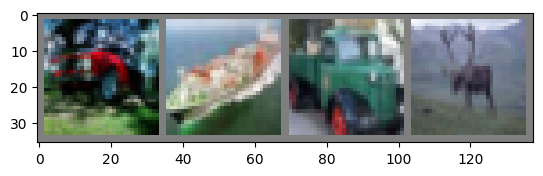

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
import os
path = os.path.join(os.getcwd(), 'cv_with_pytorch', 'datasets', 'CIFAR')

trainset = torchvision.datasets.CIFAR10(root=path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

Building the Neural Network
---------------------------

Create a convolutional neural network that classifies the category of the images in the CIFAR10 dataset. In the class below, there are two functions: `__init__` and `forward()`. In the constructor, instantiate the layers that you will need. In the `forward()` function, call these layers in order to run the neural network forwards.

Experiment with the below neural network layers to build a network that is able to classify the image:
- <a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html">nn.Conv2d()</a>
- <a href="https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d">nn.MaxPool2d()</a>
- <a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear">nn.Linear()</a>
- <a href="https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU">nn.ReLU()</a>

The input `x` will be an tensor of size `4x3x32x32`, which represents a batch of input images. The output should be a ten dimensional vector. You will most likely need to use other PyTorch operations as well, such as `torch.flatten()`. Feel free to use other layers and operations as you see fit.

We recommend first trying the following neural network: convolution, max pooling, convolution, max pooling, convolution, convolution, flattening, linear, linear, linear. Note that you should put the activation function in the right spots.

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.activation = nn.ReLU()
        self.conv2 = nn.Conv2d(10, 10, kernel_size=2)
        self.conv3 = nn.Conv2d(10, 6, kernel_size=2)
        self.conv4 = nn.Conv2d(6, 5, kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(5*5*5, 80)
        self.linear2 = nn.Linear(80, 40)
        self.linear3 = nn.Linear(40, 10)

    def forward(self, x):
        # Implement the forward pass with using the layers defined above
        # and the proper activation functions
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

net = Net()

Before we proceed, let's visualize the weights of the first convolutional layer in the neural network. Modify the code below in order to plot the weights of the first convolutional layer. (You need to use `detach()` in order for this to work.)

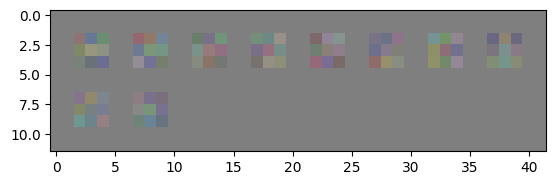

In [11]:
imshow(torchvision.utils.make_grid(net.conv1.weight.cpu().detach()))

Training the Network
--------------------

Since the neural network is initialized with random noise, the filters visualized above are just random noise. In order to train them, we need to specify both a) a loss function and b) an optimization algorithm. We will use the cross entropy loss function with stochastic gradient descent. In PyTorch, we can specify these by creating the two objects below:

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Notice that the optimizer accepts the parameter `net.parameters()`. The call `net.parameters()` is a bit of magic. It will automatically determine which tensors are learnable inside the network, and pack them into a vector that is fed into the gradient descent method. In the previous homework, you needed to manually track these variables, but in PyTorch there is book-keeping underneath the API that does this for you automatically.

Now, we are ready to train the neural network.

In [13]:
def train_network(net, n_epochs=2):
    net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if i % 1000 == 0:
                print(f'Epoch={epoch + 1} Iter={i + 1:5d} Loss={loss.item():.3f}')
                running_loss = 0.0
    print('Finished Training')
    return net


If you want, you can train the network for longer too. This will help improve the performance.

In [14]:
train_network(net, n_epochs=5)

Epoch=1 Iter=    1 Loss=2.398
Epoch=1 Iter= 1001 Loss=2.285
Epoch=1 Iter= 2001 Loss=2.254
Epoch=1 Iter= 3001 Loss=2.116
Epoch=1 Iter= 4001 Loss=1.912
Epoch=1 Iter= 5001 Loss=1.633
Epoch=1 Iter= 6001 Loss=1.532
Epoch=1 Iter= 7001 Loss=1.471
Epoch=1 Iter= 8001 Loss=1.766
Epoch=1 Iter= 9001 Loss=1.644
Epoch=1 Iter=10001 Loss=1.620
Epoch=1 Iter=11001 Loss=1.254
Epoch=1 Iter=12001 Loss=0.744
Epoch=2 Iter=    1 Loss=1.877
Epoch=2 Iter= 1001 Loss=1.407
Epoch=2 Iter= 2001 Loss=1.374
Epoch=2 Iter= 3001 Loss=1.965


KeyboardInterrupt: 

Visualizing Predictions
-----------------------

Unless you train the neural network for a long time, the loss will most likely not go to zero. However, it should still go down, which means it has learned some association between visual patterns and the category labels in the dataset. Let's try the model on some images in the test set and see what it predicts for them.

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

net.to(device)
predictions = net(images.to(device)).argmax(axis=1).cpu().detach()
accuracy = (labels==predictions).double().mean()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predictions: ', '\t'.join(f'{classes[predictions[j]]:5s}' for j in range(4)))
print(f'Accuracy: {accuracy*100}%')

In our implementation, the predictions are not always correct, but they are often reasonable. This is impressive considering we have barely trained the neural network at all.

Let's calculate the accuracy on the full test set.

In [ ]:
dataiter = iter(testloader)

running_accuracy = 0
running_count = 0
for images, labels in dataiter:
  images = images.to(device)
  predictions = net(images.to(device)).argmax(axis=1).cpu().detach()
  accuracy = (labels==predictions).double().mean()

  running_accuracy += accuracy
  running_count += 1

print(f'Accuracy: {running_accuracy/running_count*100:.2f}%')

In our solution, we get 74% accuracy after training for about 10 minutes on the Colab GPU. Can you do better?

# 2. Problem 2: Building ResNet

Residual Network
----------------

Residual networks have become a standard architecture because they are able to efficiently scale to a large number of layers. While the state-of-the-art networks have thousands of layers, they would be too expensive to train in time for the homework deadline. Let's implement just a simple residual network.

Implement a ResNet block which contains convolutional layers with a skip connection across them. Note that the dimensions of the original input and the output of the convolutional layers may not match up for addition. Hint: one way to address this is to introduce a linear transformation (like a 1x1 kernel convolution) to resize the input when necessary. Another would be to 0-pad the input to match dimensions for addition.

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # TODO: Initialize Two Convolutional Layers in the Residual Block


        self.skip_connection = nn.Identity()
        if stride != 1 or in_channels != out_channels:
          # TODO: Use a Conv2d layer with kernel_size=1 to "resize" input
          self.skip_connection = None

    def forward(self, x):
        identity_x = self.skip_connection(x)

        # TODO: Implement Forward pass using 2 Conv Layers.
        # The addition of the original input is already done

        ##############################
        assert x.shape == identity_x.shape
        x = x + identity_x
        return x


In the code block below, complete the class for a residual network. (PyTorch has a residual network built in, but you should not use it. Instead, create a residual network using the building blocks introduced above.) We recommend the following architecture: Convolution, Maxpooling, ResNetBlock, ResNetBlock, flatten, linear, linear, linear. Be sure to use ReLU activations where necessary.

In [ ]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: initialize network layers

    def forward(self, x):
        # TODO: implement the forward pass
        return x

res_net = ResNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_net.parameters(), lr=0.0001)

After you create the network, we can use the training loop from above in order to train it.

In [ ]:
res_net = train_network(res_net, n_epochs=5)

Let's visualize some of the predictions from the trained network.

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

res_net.to(device)
predictions = res_net(images.to(device)).argmax(axis=1).cpu().detach()
accuracy = (labels==predictions).double().mean()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predictions: ', '\t'.join(f'{classes[predictions[j]]:5s}' for j in range(4)))
print(f'Accuracy: {accuracy*100}%')

Let's also calculate the accuracy on the full test set.

In [ ]:
dataiter = iter(testloader)

running_accuracy = 0
running_count = 0
for images, labels in dataiter:
  images = images.to(device)
  predictions = res_net(images.to(device)).argmax(axis=1).cpu().detach()
  accuracy = (labels==predictions).double().mean()

  running_accuracy += accuracy
  running_count += 1

print(f'Accuracy: {running_accuracy/running_count*100:.2f}%')

In our solution, we get 76% accuracy.